In [1]:
import sys
sys.path.append('..')
from glob import glob
from src.utils import *
from src.params import *
import pymc3 as pm
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
import censusdata
from rasterstats import zonal_stats

from sklearn.linear_model import LinearRegression

In [2]:
df, basin_idx, basins, coords = read_data(file_dir='../data/hierarchical_septics_v7.csv',
        cols=['ppt_2021', 'hydraulic_c', 'median_hse', 'slope', 'age_median', 'income_median'], is_balanced=True)

balancing...
repairs: 27.73092578545258%, non-repairs: 72.26907421454743%


# Check Empirical Distribution

Precipitation

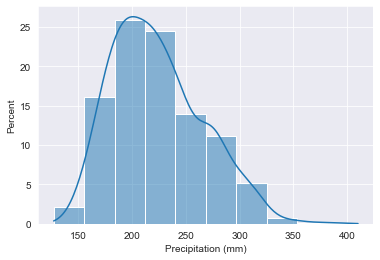

In [9]:
ax = sns.histplot(data=df, x='ppt_2021', stat="percent", bins=10, kde=True, kde_kws={'bw_adjust':3})
# ax.set_title('Distribution of Precipitation Annual Maxima in Georgia')
ax.set_xlabel('Precipitation (mm)')
plt.savefig('../docs/precip_dist.pdf', dpi=300)

Distance to water bodies

In [ ]:
ax = sns.histplot(data=df, x='water_dist', stat="percent", kde=True, kde_kws={'bw_adjust':3})
ax.set_title('Distance to Nearest Water Bodies (m) in Georgia')
ax.set_xlabel('Distance (m)')
ax.set_xlim([0,16000])
plt.savefig('../docs/wtr_dist.pdf', dpi=300)

Median Housing Values

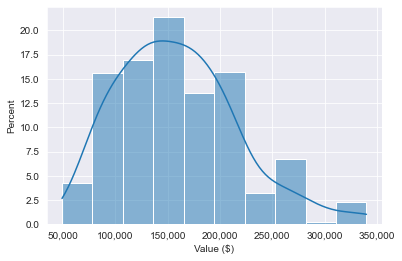

In [10]:
import matplotlib as mpl

ax = sns.histplot(data=df, x='median_hse', stat="percent", bins=10, kde=True, kde_kws={'bw_adjust':4})
# ax.set_title('Median Housing Value ($) in Georgia')
ax.set_xlabel('Value ($)')
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('../docs/hse_dist.pdf', dpi=300)

Soil Hydraulics

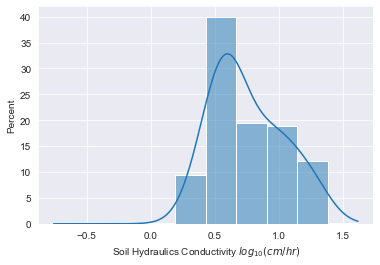

In [11]:
ax = sns.histplot(data=df, x='hydraulic_c', stat="percent", bins=10, kde=True, kde_kws={'bw_adjust':6})
# ax.set_title('Soil hydraulic conductivity in Georgia')
ax.set_xlabel('Soil Hydraulics Conductivity $log_{10}(cm/hr)$')
plt.savefig('../docs/hydr_dist.pdf', dpi=300)

Slope

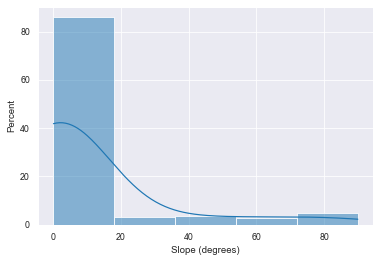

In [10]:
ax = sns.histplot(data=df, x='slope', stat="percent", bins=5, kde=True, kde_kws={'bw_adjust':8})
# ax.set_title('Digital Elevation (m) in Georgia')
ax.set_xlabel('Slope (degrees)')
plt.savefig('../docs/slope_dist.pdf', dpi=300)

DEM

Text(0.5, 0, 'Slope (m)')

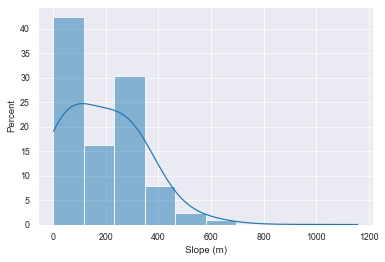

In [3]:
ax = sns.histplot(data=df, x='dem', stat="percent", bins=10, kde=True, kde_kws={'bw_adjust':8})
# ax.set_title('Digital Elevation (m) in Georgia')
ax.set_xlabel('Topographic elevation (m)')
plt.savefig('../docs/dem_dist.pdf', dpi=300)

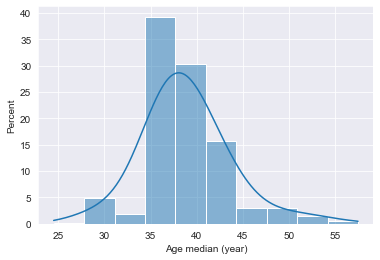

In [4]:
# Age median
ax = sns.histplot(data=df, x='age_median', stat="percent", bins=10, kde=True, kde_kws={'bw_adjust':8})
ax.set_xlabel('Age median (year)')
plt.savefig('../docs/age_dist.pdf', dpi=300)

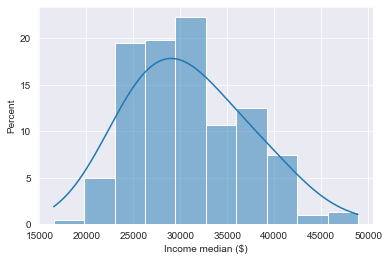

In [6]:
# Income median
ax = sns.histplot(data=df, x='income_median', stat="percent", bins=10, kde=True, kde_kws={'bw_adjust':8})
ax.set_xlabel('Income median ($)')
plt.savefig('../docs/income_dist.pdf', dpi=300)

### Normalized Version

Precipitation

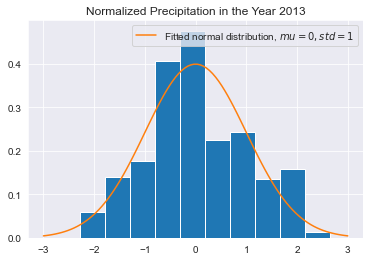

In [7]:
# plotting
x = np.linspace(-3,3,100)
y = stats.norm.pdf(x, loc=0., scale=1.)
df['ppt_2013_norm'].hist(density=True)
plt.title("Normalized Precipitation in the Year 2013")
plt.plot(x,y, label="Fitted normal distribution, $mu=0, std=1$")
plt.legend()

Distance to water bodies

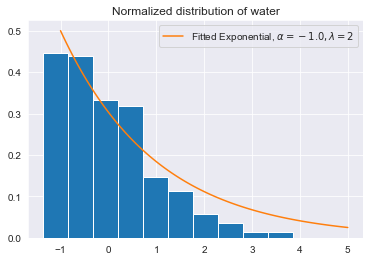

In [8]:
# plotting distribution (using Gamma distribution with alpha=1 or exponential decay)
x = np.linspace(-1,5,100)
y = stats.expon.pdf(x, loc=-1.,scale=2)
df['water_dist_norm'].hist(density=True)
plt.plot(x,y, label="Fitted Exponential, $\\alpha=-1.0, \lambda=2.$")
plt.title("Normalized distribution of water")
plt.legend()

Hydraulic Conductivity

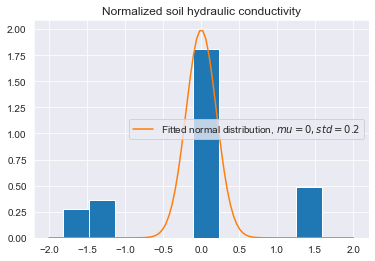

In [9]:
# plotting distribution (using Gamma distribution with alpha=1 or exponential decay)
x = np.linspace(-2,2,100)
y = stats.norm.pdf(x, loc=0., scale=0.2)
df['hydraulic_c_norm'].hist(density=True)
plt.plot(x,y, label="Fitted normal distribution, $mu=0, std=0.2$")
plt.title("Normalized soil hydraulic conductivity")
plt.legend()

Median housing values

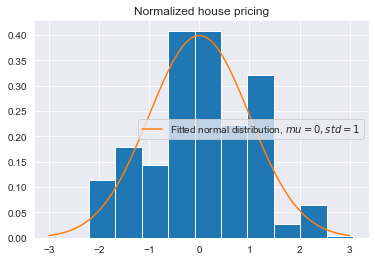

In [10]:
# plotting distribution (using Normal distribution)
x = np.linspace(-3,3,100)
y = stats.norm.pdf(x, loc=0, scale=1)
df['median_hse_norm'].hist(density=True)
plt.plot(x,y, label="Fitted normal distribution, $mu=0, std=1$")
plt.title("Normalized house pricing")
plt.legend()

DEM

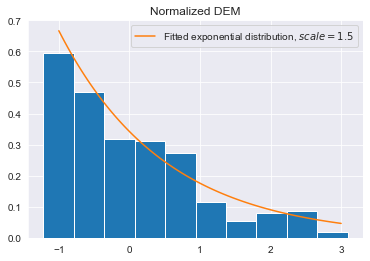

In [11]:
# plotting distribution (using Normal distribution)
x = np.linspace(-1,3,100)
y = stats.expon.pdf(x, loc=-1, scale=1.5)
df['dem_norm'].hist(density=True)
plt.plot(x,y, label="Fitted exponential distribution, $scale= 1.5$")
plt.title("Normalized DEM")
plt.legend()

# Wastewater EDA

In [3]:
df = pd.read_csv('../data/hierarchical_septics_v5.csv')

/var/folders/3_/bdv8r_590xz8hvrnflbd7dxm0000gn/T/ipykernel_11304/2214497231.py:1: DtypeWarning: Columns (8,11,13,15,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/hierarchical_septics_v5.csv')


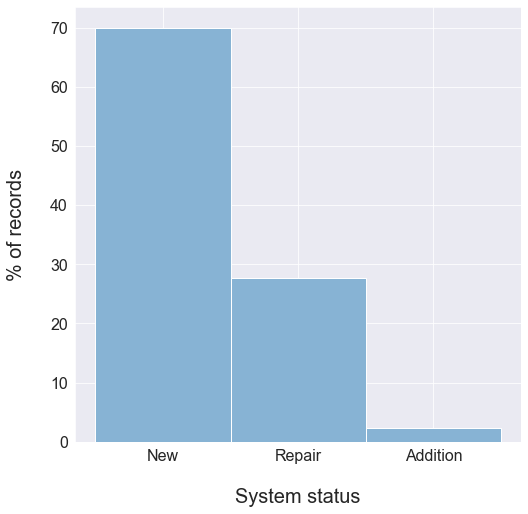

In [11]:
f, ax = plt.subplots(figsize=(8,8))
sns.histplot(data=df, x='sewageSystem', stat="percent", facecolor='#87b3d4')
ax.set_xlabel("System status", labelpad = 24, fontsize=20)
ax.set_ylabel("% of records", labelpad = 24, fontsize=20)
ax.tick_params(labelsize=16);
f.savefig('../docs/percent_status.pdf', dpi=300, bbox_inches='tight')

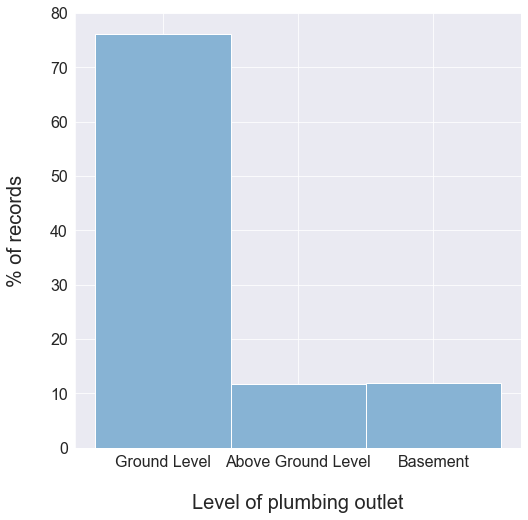

In [13]:
f, ax = plt.subplots(figsize=(8,8))
sns.histplot(data=df, x='levelOfPlumbingOutlet', stat="percent", facecolor='#87b3d4')
ax.set_xlabel("Level of plumbing outlet", labelpad = 24, fontsize=20)
ax.set_ylabel("% of records", labelpad = 24, fontsize=20)
ax.tick_params(labelsize=16);
f.savefig('../docs/percent_plumbing.pdf', dpi=300, bbox_inches='tight')

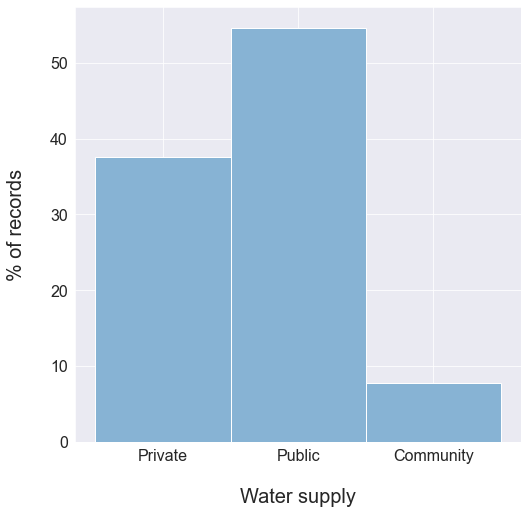

In [19]:
f, ax = plt.subplots(figsize=(8,8))
sns.histplot(data=df[df['waterSupply'] != '3'], x='waterSupply', stat="percent", facecolor='#87b3d4')
ax.set_xlabel("Water supply", labelpad = 24, fontsize=20)
ax.set_ylabel("% of records", labelpad = 24, fontsize=20)
ax.tick_params(labelsize=16);
f.savefig('../docs/percent_watersupply.pdf', dpi=300, bbox_inches='tight')

Wastewater system distribution

<AxesSubplot:>

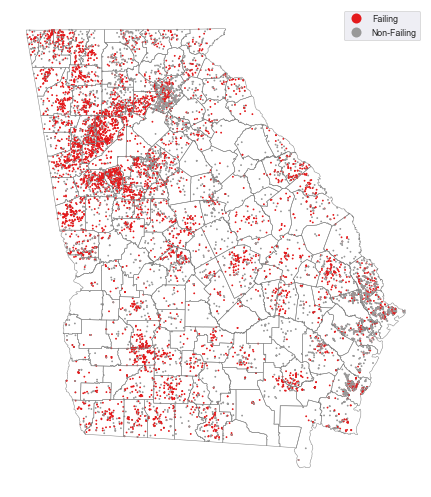

In [54]:
# Random balancing
df = pd.read_csv('../data/hierarchical_septics_v5.csv')

# encode categorical sewage system
enc, _ = pd.factorize(df['sewageSystem'])
df['sewageSystem_enc'] = enc
df.loc[df['sewageSystem_enc'] == 1, 'sewageSystem_enc'] = 'Failing' # need repair
df.loc[(df['sewageSystem_enc'] == 0) | (df['sewageSystem_enc'] == 2), 'sewageSystem_enc'] = 'Non-Failing' # new + addition

# get balanced class (septics needing repair are not as many)
num = len(df[df['sewageSystem_enc'] == 'Failing'].values)
# print(f'balancing...\nrepairs: {num/len(df)*100}%, non-repairs: {(len(df) - num)/len(df)*100}%')

# split equally
idx = df[df['sewageSystem_enc'] == 'Non-Failing']
df = pd.concat((df.sample(n=len(idx), random_state=42), df[df['sewageSystem_enc'] == 'Failing']))

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['tblSGA_Property.gis_long_property'], df['tblSGA_Property.gis_lat_property']))
gdf.set_crs('EPSG:4326', inplace=True)
f, ax = plt.subplots(figsize=(7,7))
sampled_gdf = gdf.sample(n=12000)
sampled_gdf.plot(column='sewageSystem_enc', categorical=True, cmap='Set1', markersize=1, legend=True, ax=ax)
ax.axis('off')
f.tight_layout()

# Boundary
boundary_f = '../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp'
bdry = gpd.read_file(boundary_f)
state_bdry = bdry[bdry['STATEFP'] == "13"]
state_bdry.boundary.plot(edgecolor='grey', linewidth=0.5, ax=ax)

# f.savefig('../docs/ga_system_dist.pdf', dpi=300, bbox_inches='tight')

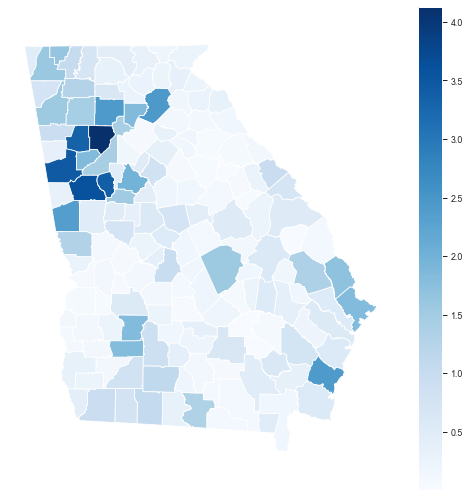

In [55]:
# Combine percentage to state boundary and plot
f, ax = plt.subplots(figsize=(7,7))
failing_gdf = gdf[gdf['sewageSystem_enc'] == 'Failing']
combined_df = failing_gdf.sjoin(state_bdry, how='left')
failing_size = combined_df.groupby('NAME').size()
failing_perc = failing_size / sum(failing_size) * 100
failing_perc = failing_perc.reset_index()
failing_perc = failing_perc.rename(columns={0: 'failing_percentage'})
state_bdry = state_bdry.merge(failing_perc, on='NAME')
state_bdry.plot(column='failing_percentage', ax=ax, cmap='Blues', legend=True)
ax.axis('off')
f.tight_layout()

# Correlation of inputs X and attributes Z

In [53]:
def get_inference_data(indep_srcs, state_id):
    def _get_acs_df(dict):
        acs = (censusdata.download(
            acs_dict['type'],acs_dict['year'], 
            censusdata.censusgeo([('state', acs_dict['state']), ('county', '*')]), [acs_dict['code']]
        ).reset_index().rename(columns={acs_dict['code']: acs_dict['col_name']}))

        for i, row in acs.iterrows():
            county = (str(row['index'])
                        .split(',')[0]
                        .split('County')[0]
                        .strip())

            acs.loc[i, 'County'] = county
        
        for i, row in state_bdry.iterrows():
            try:
                hse_mean = acs[acs['County'] == row['NAME']][acs_dict['col_name']].item()
                state_bdry.loc[i, acs_dict['col_name']] = hse_mean
            except:
                state_bdry.loc[i, acs_dict['col_name']] = 0

    state_id = str(state_id)

    # Get boundary
    bdry = gpd.read_file(indep_srcs['bdry'])
    state_bdry = bdry[bdry['STATEFP'] == state_id].reset_index(drop=True)
    outer_bdry = state_bdry.dissolve()
    del indep_srcs['bdry']

    # Get raster median value for each county
    for indep_var in indep_srcs.keys():
        filename = indep_srcs[indep_var]
        with rio.open(filename) as src:
            affine = src.transform
            array = src.read(1)
            
            # convert to slope
            if indep_var == 'slope':
                array = np.where(array == 32767, np.nan, array)
                res = src.res[0]  # pixel resolution in degrees
                elevation_deg = np.degrees(np.arctan(array / np.sqrt(res**2 + res**2)))
                slope_x, slope_y = np.gradient(elevation_deg, res, res)
                array = np.degrees(np.arctan(np.sqrt(slope_x**2 + slope_y**2)))
                
            zones = pd.DataFrame(zonal_stats(state_bdry, array, affine=affine, stats='median'))
        
        var_name = f'{indep_var}_median'
        state_bdry[var_name] = zones['median']

    # Get censusdata value
    acs_dict_list = [
        {'type': 'acs5','year': 2021,'state': state_id,'code': 'B25077_001E','col_name': 'hse_median'}, 
        {'type': 'acs1','year': 2021,'state': state_id,'code': 'B17002_002E','col_name': 'poverty_income_ratio'},
        {'type': 'acs5','year': 2021,'state': state_id,'code': 'B01003_001E','col_name': 'population_size'},
        {'type': 'acs5','year': 2021,'state': state_id,'code': 'B06002_001E','col_name': 'age_median'},
        {'type': 'acs5','year': 2021,'state': state_id,'code': 'B07411_001E','col_name': 'income_median'}
    ]
    for acs_dict in acs_dict_list:
        _get_acs_df(acs_dict)

    # Normalize poverty_income_ratio with population size
    state_bdry['poverty_income_ratio'] = state_bdry['poverty_income_ratio'] / state_bdry['population_size']
    
    return state_bdry

In [55]:
state_id = state_codes['GA']
indep_srcs = {
    'bdry': '../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp',
    'ppt': '../../Data/precipitation/annual_max_2021.tif',
    'soil': '../../Data/soil/mosaic/GA.tif',
    'slope': '../../Data/dem/hyd_na_dem_15s.tif',
}
gdf = get_inference_data(indep_srcs, state_id=state_id)
for var in ['ppt_median', 'soil_median', 'slope_median', 'hse_median', 'poverty_income_ratio', 'age_median', 'income_median']:
    gdf[var] = (gdf[var] - gdf[var].mean()) / gdf[var].std() # z-normalize
gdf.reset_index(drop=True, inplace=True)
gdf.fillna(0., inplace=True)

In [56]:
# Perform pairwise correlation
A_cols = ['ppt_median', 'soil_median', 'slope_median', 'hse_median']
B_cols = ['poverty_income_ratio', 'age_median', 'income_median']
A = gdf[A_cols].to_numpy()
B = gdf[B_cols].to_numpy()
N = B.shape[0]
sig = 2/np.sqrt(N)

# Store columnw-wise in A and B, as they would be used at few places
sA = A.sum(0)
sB = B.sum(0)

# Basically there are four parts in the formula. We would compute them one-by-one
p1  = N*np.dot(B.T,A)
p2 = sA*sB[:,None]
p3 = N*((B**2).sum(0)) - (sB**2)
p4 = N*((A**2).sum(0)) - (sA**2)

# Finally compute Pearson Correlation Coefficient as 2D array 
pcorr = ((p1 - p2)/np.sqrt(p4*p3[:,None]))
df = pd.DataFrame(pcorr, columns=A_cols, index=B_cols)
df[abs(df) > sig]

,ppt_median,soil_median,slope_median,hse_median
poverty_income_ratio,NaN,NaN,NaN,0.350666
age_median,NaN,-0.165681,NaN,NaN
income_median,-0.258821,-0.364264,NaN,0.866404


In [57]:
# Perform pairwise correlation
A_cols = ['ppt_median', 'soil_median', 'slope_median', 'hse_median']
B_cols = ['poverty_income_ratio', 'age_median', 'income_median']
A = gdf[A_cols+B_cols].to_numpy()
B = gdf[A_cols+B_cols].to_numpy()
N = B.shape[0]
sig = 2/np.sqrt(N)

# Store columnw-wise in A and B, as they would be used at few places
sA = A.sum(0)
sB = B.sum(0)

# Basically there are four parts in the formula. We would compute them one-by-one
p1  = N*np.dot(B.T,A)
p2 = sA*sB[:,None]
p3 = N*((B**2).sum(0)) - (sB**2)
p4 = N*((A**2).sum(0)) - (sA**2)

# Finally compute Pearson Correlation Coefficient as 2D array 
pcorr = ((p1 - p2)/np.sqrt(p4*p3[:,None]))
df = pd.DataFrame(pcorr, columns=A_cols+B_cols, index=A_cols+B_cols)
df[abs(df) > sig]

,ppt_median,soil_median,slope_median,hse_median,poverty_income_ratio,age_median,income_median
ppt_median,1.000000,0.279019,0.233823,NaN,NaN,NaN,-0.258821
soil_median,0.279019,1.000000,NaN,-0.466070,NaN,-0.165681,-0.364264
slope_median,0.233823,NaN,1.000000,NaN,NaN,NaN,NaN
hse_median,NaN,-0.466070,NaN,1.000000,0.350666,NaN,0.866404
poverty_income_ratio,NaN,NaN,NaN,0.350666,1.000000,-0.452733,0.373931
age_median,NaN,-0.165681,NaN,NaN,-0.452733,1.000000,-0.225728
income_median,-0.258821,-0.364264,NaN,0.866404,0.373931,-0.225728,1.000000


In [58]:
# Regression coefficients and intercepts
sig = 2/np.sqrt(N)
y_cols = ['ppt_median', 'soil_median', 'slope_median', 'hse_median']
X_cols = ['poverty_income_ratio', 'age_median', 'income_median']

coeffs = list()
intercepts = list()
for y_col in y_cols:
    coeffs.append(LinearRegression().fit(gdf[X_cols], gdf[y_col]).coef_)
    intercepts.append(LinearRegression().fit(gdf[X_cols], gdf[y_col]).intercept_)

df = pd.DataFrame(np.array(coeffs), columns=X_cols, index=y_cols)
df['intercept'] = np.array(intercepts)
df[abs(df) > sig]

,poverty_income_ratio,age_median,income_median,intercept
ppt_median,NaN,NaN,-0.246727,NaN
soil_median,NaN,-0.312900,-0.385096,NaN
slope_median,NaN,NaN,NaN,NaN
hse_median,NaN,0.209811,0.868567,NaN


In [59]:
# Regressing on the basin params
state_id = state_codes['GA']
indep_srcs = {
    'bdry': '../../Data/boundary/cb_2018_us_county_500k/cb_2018_us_county_500k.shp',
    'ppt': '../../Data/precipitation/annual_max_2021.tif',
    'soil': '../../Data/soil/mosaic/GA.tif',
    'slope': '../../Data/dem/hyd_na_dem_15s.tif',
}
gdf = get_inference_data(indep_srcs, state_id=state_id)
basin_params = pd.read_csv('../tmp/basin_params_with_attributes_v2.csv')
params = ['ppt', 'hydr', 'slope_y', 'hse', 'c']
for param in params:
    gdf[param] = basin_params[param]

for var in ['ppt_median', 'soil_median', 'slope_median', 'hse_median', 'poverty_income_ratio', 'age_median', 'income_median']:
    gdf[var] = (gdf[var] - gdf[var].mean()) / gdf[var].std() # z-normalize
gdf.reset_index(drop=True, inplace=True)
gdf.fillna(0., inplace=True)

In [60]:
y_cols = ['ppt_median', 'soil_median', 'slope_median', 'hse_median', 'c']
X_cols = ['poverty_income_ratio', 'age_median', 'income_median']
N = gdf.shape[0]
sig = 2/np.sqrt(N)

coeffs = list()
intercepts = list()
for y_col in y_cols:
    coeffs.append(LinearRegression().fit(gdf[X_cols], gdf[y_col]).coef_)
    intercepts.append(LinearRegression().fit(gdf[X_cols], gdf[y_col]).intercept_)

df = pd.DataFrame(np.array(coeffs), columns=X_cols, index=y_cols)
df['intercept'] = np.array(intercepts)
df[abs(df) > sig]

,poverty_income_ratio,age_median,income_median,intercept
ppt_median,NaN,NaN,-0.246727,NaN
soil_median,NaN,-0.312900,-0.385096,NaN
slope_median,NaN,NaN,NaN,NaN
hse_median,NaN,0.209811,0.868567,NaN
c,0.177777,NaN,NaN,NaN
